In [36]:
# imports
import pathlib, glob
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
repo_root_dir = pathlib.Path().resolve().parent

xrd_data_dir = repo_root_dir.parent/"xrd_example_files"

xrd_data_file_paths = glob.glob(f"{xrd_data_dir}/*.csv")

In [3]:
xrd_data_file = xrd_data_file_paths[0]

In [4]:
with open(xrd_data_file,"r") as fp:
    line_1 = fp.readline()
    line_2 = fp.readline()
    raw_file_name = line_2.split(",")[-1]
print(raw_file_name)

ML_Wallace_17122019_1_NN_1_ZrP_Crucible_12x16_14x161of2Crucibles_BlackPowder_5-60_4min_BkgSubtracted.raw



In [39]:
xrd_df = pd.read_csv(xrd_data_file, skiprows=2, names=["angle","counts"])

In [54]:
BG_PERCENTILE = 95.

bg_height = np.percentile(xrd_df["counts"],BG_PERCENTILE)

peaks, _ = scipy.signal.find_peaks(xrd_df["counts"], height=bg_height)
peak_angles = xrd_df["angle"].iloc[peaks]
peak_counts = xrd_df["counts"].iloc[peaks]

In [55]:
INTERVAL_SIZE = None

angle_precisions = xrd_df["angle"].apply(lambda x: len(str(x).split('.')[1]) if '.' in str(x) else 0)
max_precision = max(angle_precisions)
print(f"Angles have at most {max_precision} decimal places")

step_sizes = xrd_df["angle"].diff().dropna().round(max_precision-1)

if step_sizes.nunique()==1:
    INTERVAL_SIZE = step_sizes.iloc[0]
    print(f"interval size is {INTERVAL_SIZE}")
else:
    raise ValueError(f"Angles are not all evenly spaced! Found intervals: {step_sizes.unique()}")

Angles have at most 7 decimal places
interval size is 0.018586


In [69]:
NEIGHBORHOOD_SIZE = 20 * INTERVAL_SIZE
MIN_N_INTERVAL_SEPARATION = 10

peak_segments = []
peak_angles_done = set()
for peak_angle, peak_count in zip(peak_angles, peak_counts):
    if peak_angle in peak_angles_done:
        continue
    last_peaks_in_seg = []
    peaks_in_seg = [(peak_angle, peak_count)]
    while peaks_in_seg != last_peaks_in_seg:
        segment_min_angle = min([p[0] for p in peaks_in_seg]) - NEIGHBORHOOD_SIZE
        segment_max_angle = max([p[0] for p in peaks_in_seg]) + NEIGHBORHOOD_SIZE
        last_peaks_in_seg = peaks_in_seg
        peaks_in_seg = [
            (p_a, p_c)
            for p_a, p_c in zip(peak_angles, peak_counts)
            if p_a >= segment_min_angle and p_a <= segment_max_angle
        ]
    for p_a, p_c in peaks_in_seg:
        peak_angles_done.add(p_a)
    filtered_peaks = []
    for p_a, p_c in peaks_in_seg:
        nearby_peaks_counts = [p_c_other for p_a_other, p_c_other in peaks_in_seg if abs(p_a-p_a_other)<MIN_N_INTERVAL_SEPARATION*INTERVAL_SIZE and p_a_other!=p_a]
        if len(nearby_peaks_counts)<1 or p_c==max([p_c,*nearby_peaks_counts]):
            filtered_peaks.append((p_a,p_c))
    peaks_in_seg = filtered_peaks
    peak_segments.append(
        {"min": segment_min_angle, "max": segment_max_angle, "peak_angles": [p[0] for p in peaks_in_seg], "peak_counts": [p[1] for p in peaks_in_seg]}
    )
    print(
        f"Segment from {segment_min_angle} to {segment_max_angle} includes peaks at {[p[0] for p in peaks_in_seg]}"
    )

Segment from 27.5259856 to 29.254473 includes peaks at [27.953463, 28.23225, 28.4738654, 28.882753]
Segment from 31.0572876 to 31.9122424 includes peaks at [31.4661792]
Segment from 34.9974772 to 35.7966746 includes peaks at [35.3691972]
Segment from 39.959885799999995 to 40.870598 includes peaks at [40.3316058]
Segment from 45.628554799999996 to 46.483509600000005 includes peaks at [46.0002748]
Segment from 49.048342 to 49.97764 includes peaks at [49.420062]
Segment from 57.634981599999996 to 58.564279600000006 includes peaks at [58.0067016]
Segment from 58.6943722 to 59.5679128 includes peaks at [59.1218496]


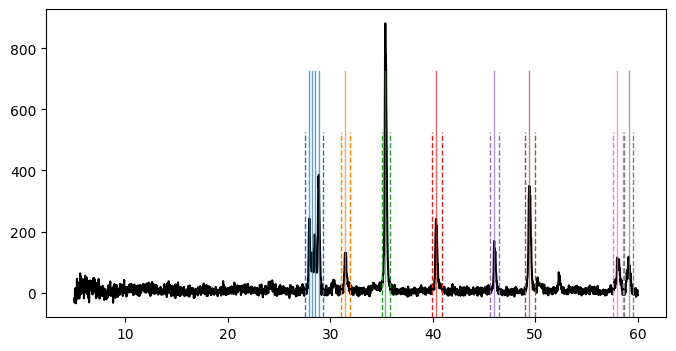

In [70]:
color_names = list(mcolors.TABLEAU_COLORS.keys())

f,ax = plt.subplots(figsize=(8.,4.))
ax.plot(xrd_df["angle"],xrd_df["counts"],color="black")
for i_seg, peak_segment in enumerate(peak_segments):
    color = color_names[i_seg%(len(color_names)-1)]
    ax.axvline(peak_segment["min"],color=color,linewidth=1,ymax=0.6,linestyle="--")
    ax.axvline(peak_segment["max"],color=color,linewidth=1,ymax=0.6,linestyle="--")
    for peak_angle in peak_segment["peak_angles"]:
        ax.axvline(peak_angle,color=color,linewidth=1,ymax=0.8,alpha=0.7)
plt.show()